In [4]:
import string
import random
import re
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import init
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
text = open('./tinyshakespeare.txt').read()
text_len = len(text)

all_characters = string.printable
n_characters = len(all_characters)

In [6]:
def get_chunk(chunk_len=100):
    start_index = random.randint(0, text_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

def to_tensor(string, dtype='float'):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

def random_training_set():    
    chunk = get_chunk()
    inp = to_tensor(chunk[:-1])
    target = to_tensor(chunk[1:])
    return inp, target

In [7]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1, htype='rnn', lr=0.005):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.htype = htype
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        print(htype)
        if htype=='rnn':
            self.model = nn.RNN(hidden_size, hidden_size, n_layers)
        elif htype=='lstm':
            self.model = nn.LSTM(hidden_size, hidden_size, n_layers)
        elif htype=='gru':
            self.model = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
        
        self.optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.model(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden
    
    def evaluate(self, prime_str='T', predict_len=500, temperature=0.8):
        hidden = self.init_hidden()
        prime_input = to_tensor(prime_str)
        predicted = prime_str
        
        # Use priming string to "build up" hidden state
        for p in range(len(prime_str) - 1):
            _, hidden = self(prime_input[p], hidden)
        inp = prime_input[-1]

        for p in range(predict_len):
            output, hidden = self(inp, hidden)

            # Sample from the network as a multinomial distribution
            output_dist = output.data.view(-1).div(temperature).exp()
            top_i = torch.multinomial(output_dist, 1)[0]

            # Add predicted character to string and use as next input
            predicted_char = all_characters[top_i]
            predicted += predicted_char
            inp = to_tensor(predicted_char)

        return predicted
    
    def train(self, inp, target, chunk_len=100):
        hidden = self.init_hidden()
        self.zero_grad()
        loss = 0

        for c in range(chunk_len):
            output, hidden = self(inp[c], hidden)
            loss += self.criterion(output, target[c])

        loss.backward()
        self.optimizer.step()

        return loss.data[0]/chunk_len

    def init_hidden(self):
        if self.htype == "lstm":
            return (Variable(torch.zeros(self.n_layers, 1, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, 1, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size),\
                        requires_grad=True)

In [8]:
n_epochs = 2000
print_every = 100
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

In [9]:
model = Model(n_characters, hidden_size, n_characters, n_layers, htype='rnn')
print(model)

rnn
Model(
  (encoder): Embedding(100, 100)
  (model): RNN(100, 100)
  (decoder): Linear(in_features=100, out_features=100, bias=True)
  (criterion): CrossEntropyLoss(
  )
)


In [10]:
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = model.train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[(%d %d%%) %.4f]' % (epoch, 1.*epoch/n_epochs*100, loss))
        #print(model.evaluate('Wh', 100))
        #print('\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

[(100 5%) 2.3918]
[(200 10%) 2.3286]
[(300 15%) 2.0976]
[(400 20%) 2.2957]
[(500 25%) 2.1071]
[(600 30%) 2.2894]
[(700 35%) 2.2599]
[(800 40%) 2.1847]
[(900 45%) 2.4030]
[(1000 50%) 2.1097]
[(1100 55%) 1.9414]
[(1200 60%) 2.1530]
[(1300 65%) 2.1673]
[(1400 70%) 1.9575]
[(1500 75%) 2.1183]
[(1600 80%) 1.6135]
[(1700 85%) 2.1906]
[(1800 90%) 2.2060]
[(1900 95%) 1.6811]
[(2000 100%) 1.9493]


In [12]:
print(model.evaluate('Th', 600))

Thou the maid!

KENCEN'NARINARANIO:
I my reselo, atre, the your or upons so my brom lords aser at low now dived
The like exced we and you for not fid for fare from flliaess:
Noaked deat me fairn dud to his not exend, and a my men,
Clord.
OMth lold man and you with my sting what this to taker ert have me and do tone kint lived all me,
Had the eet dones! me forimed!

VETRUCHIOF OF OFPEONIUS:
With lawh, the lible this there of with and weck my deever forst I for ind?

HERSTHUENIO:
And tust in and foth firm not and rece to his heremming. Sere say will mand my my now all ment own my laince from hast 


Text(0,0.5,'Loss')

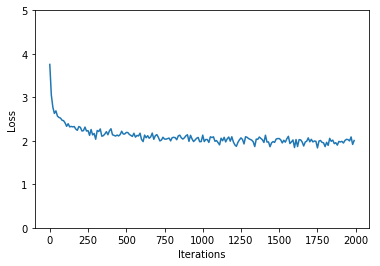

In [15]:
plt.figure()
plt.plot(range(0,2000,10),all_losses)
plt.ylim(0,5)
plt.xlabel('Iterations')
plt.ylabel('Loss')